# Grover algorithm explained with matrices calculus

author: [Łukasz Herok](https://lukaszherok.com)

This notebook goes througt the [Qiskit Textbook Grover's algorithm](https://community.qiskit.org/textbook/ch-algorithms/grover.html#Grover's-Algorithm)  explaining it in more details, showing how to apply the matrix calculus. Before going furhter with this tutorial, you should get familiar with the theoretical [Introduction](https://community.qiskit.org/textbook/ch-algorithms/grover.html#1.-Introduction-) in the Qiskit Textbook.

Grover algoriths is for searching the unstructded database. In this example is shown, how to perform the Groover's algorithm, to make a quantum system to reveal the marked states.

**Preparation part**

*Latex math*
$$ \def\ket#1{\lvert #1 \rangle}\def\bra#1{\langle #1 \rvert} $$

*Quantum Gates as matrices*

In [20]:
import numpy as np
from qiskit.extensions import HGate, CnotGate, IdGate, XGate, CzGate, ZGate

# |0>, |1>
zero = np.array([[1.],
                 [0.]]) 

one = np.array([[0.],
                [1.]]) 

# Gates: I, Z, H, X
I = IdGate().to_matrix()
Z = ZGate().to_matrix()
H = 1./np.sqrt(2) * np.array([[1, 1],
                              [1, -1]])
X = XGate().to_matrix()

# 3-qubit Hadamard gate
Hq012 = np.kron(np.kron(H,H),H)

# 3-qubit CZ gates
p00 = zero * np.array([1, 0]) # |0><0|
p11 = one * np.array([0, 1]) # |1><1|
# control = 1 (|0><0| + |1><1|), target = 0 (Z), uninvoled =2 (I)
# 012 + 012 - qubit indexint
cz10 = np.kron(np.kron(I, p00), I) + np.kron(np.kron(Z, p11), I)
cz20 = np.kron(np.kron(I, I), p00) + np.kron(np.kron(Z, I), p11)

# 3-qubit CCZ gate
# control = (|0><0| + |1><1|), 
# target = (Z)
# control = 21
# target  = 0 
ccz210 = np.kron(np.kron(I, p00), p00) + np.kron(np.kron(Z, p11), p11)


*Qiskit*

In [2]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

## Example

According to the [example](https://community.qiskit.org/textbook/ch-algorithms/grover.html#2.-Example--).
We have got three qubit system and we want to make it to return our two marked states: $\ket{101}$ and $\ket{110}$.

**1. Build 3 qubit register**

Combine 3 qubits in state |0> to make one three qubit register: |000> [^lh-tut-qubytes]
$$ \ket{\psi} = \ket{000} $$

**matrix:**

In [3]:
state = np.kron(np.kron(zero, zero), zero)
state

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

Note, you can treat is as bit string, calucluateing the value of the state form binnary to decemial (eg. |000> = 0, |101> = 5) tells you when the `1` is int the vector (on the 0th or 5th postion accordinglgy)

**qiskit:**

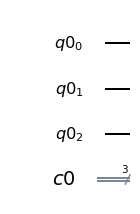

In [4]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
circ = QuantumCircuit(q, c)

circ.draw(output='mpl')


**2. Superposiotion**

Apply Hadamard gates to $3$ qubits initialised to $\ket{000}$ to create a uniform superposition:

$$ \ket{\psi_1} = H\ket{\psi}$$ 

  $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right) $$

**matrix:**

In [5]:

state = np.dot(Hq012, state)
state

array([[0.35355339],
       [0.35355339],
       [0.35355339],
       [0.35355339],
       [0.35355339],
       [0.35355339],
       [0.35355339],
       [0.35355339]])

**qiskit:**

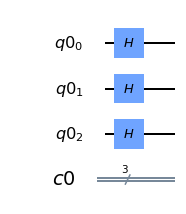

In [6]:
circ.h(q)
circ.draw(output='mpl')

**3. Oracle**

(put the circuit graph here, with highlighted the oracle)


Mark states $\lvert101\rangle$ and $\lvert110\rangle$ using a phase oracle:

$$\ket{\psi_2} = CZ_{10}\ket{CZ_{20}\ket{\psi_1}} $$


  $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right) $$


**math:**

In [7]:
oracle =cz20*cz10
state = np.dot(oracle, state)
state

array([[ 0.35355339+0.j],
       [ 0.35355339+0.j],
       [ 0.35355339+0.j],
       [ 0.35355339+0.j],
       [ 0.35355339+0.j],
       [-0.35355339+0.j],
       [-0.35355339+0.j],
       [ 0.35355339+0.j]])

**qiskit:**

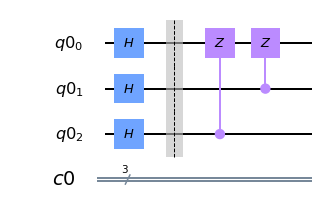

In [8]:
circ.barrier() # for readabilty
circ.cz(q[2], q[0])
circ.cz(q[1], q[0])
circ.draw(output='mpl')

**4. Amplify probability**

a). Apply Hadamard gates to the qubits:
$$ \ket{\psi_{3a}} = H\ket{\psi_2} $$ 

$$\lvert \psi_{3a} \rangle = \frac{1}{2} \left( 
        \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$

**matrix:**

In [9]:
state = np.dot(Hq012, state)
state

array([[ 5.00000000e-01+0.j],
       [ 0.00000000e+00+0.j],
       [ 2.77555756e-17+0.j],
       [ 5.00000000e-01+0.j],
       [ 5.00000000e-01+0.j],
       [ 0.00000000e+00+0.j],
       [ 2.77555756e-17+0.j],
       [-5.00000000e-01+0.j]])

**qiskit:**

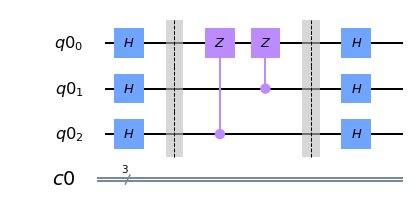

In [10]:
circ.barrier() # for readabilty
circ.h(q)
circ.draw(output='mpl')

b). Apply X gates to the qubits:
$$ \ket{\psi_{3b}} = X\ket{\psi_{3a}} $$ 
$$\lvert \psi_{3b} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right) $$

In [11]:
Xq012 = np.kron(np.kron(X,X), X)
state = np.dot(Xq012, state)
state

array([[-5.00000000e-01+0.j],
       [ 2.77555756e-17+0.j],
       [ 0.00000000e+00+0.j],
       [ 5.00000000e-01+0.j],
       [ 5.00000000e-01+0.j],
       [ 2.77555756e-17+0.j],
       [ 0.00000000e+00+0.j],
       [ 5.00000000e-01+0.j]])

**qiskit:**

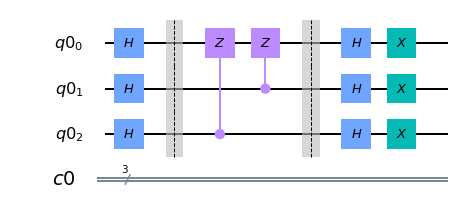

In [12]:
circ.x(q)
circ.draw(output='mpl')

c). Apply a doubly controlled Z gate between the 0, 1 (controls) and 2 (target) qubits

$$ \ket{\psi_{3c}} = CCZ_{012}\ket{\psi_{3b}} $$ 

$$ \lvert \psi_{3c} \rangle = \frac{1}{2} \left(-\lvert000\rangle +\lvert011\rangle  +\lvert100\rangle -\lvert111\rangle \right) $$

**matrix:**

In [13]:
state = np.dot(ccz210, state)
state

array([[-0.5+0.j],
       [ 0. +0.j],
       [ 0. +0.j],
       [ 0.5+0.j],
       [ 0.5+0.j],
       [ 0. +0.j],
       [ 0. +0.j],
       [-0.5+0.j]])

**qiskit:**

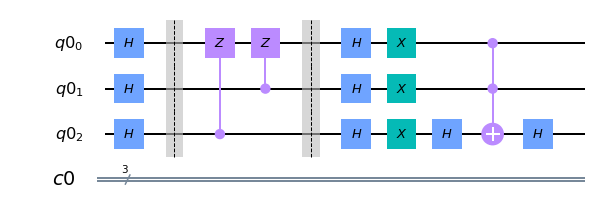

In [14]:
# There is no ccz gate in qiskit so we need to implement it using h-ccx-h
circ.h(q[2])
circ.ccx(q[0], q[1], q[2])
circ.h(q[2])
circ.draw(output='mpl')

d). Apply X gates to the qubits

$$ \ket{\psi_{3d}} = X\ket{\psi_{3c}} $$

 $$\lvert \psi_{3d} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$

**matrix:**

In [15]:
state = np.dot(Xq012, state)
state

array([[-0.5+0.j],
       [ 0. +0.j],
       [ 0. +0.j],
       [ 0.5+0.j],
       [ 0.5+0.j],
       [ 0. +0.j],
       [ 0. +0.j],
       [-0.5+0.j]])

**qiskit:**

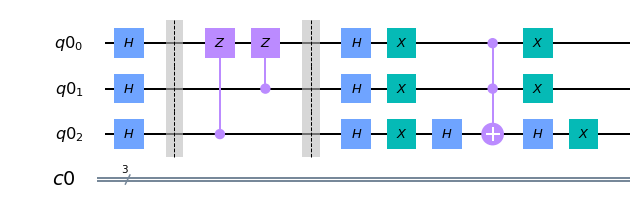

In [16]:
circ.x(q)
circ.draw(output='mpl')

e). Apply Hadamard gates to the qubits

$$ \ket{\psi_{3e}} = H\ket{\psi_{3d}} $$
$$\lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( 
        -\lvert101\rangle -\lvert110\rangle \right) $$

**matrix:**

In [17]:
state = np.dot(Hq012, state)
state

array([[ 0.00000000e+00+0.j],
       [ 9.52420783e-18+0.j],
       [ 9.52420783e-18+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [-7.07106781e-01+0.j],
       [-7.07106781e-01+0.j],
       [ 0.00000000e+00+0.j]])

Results 5: |101>, 6: |110>.

(look carefully that states 1 = |001>, and 2 = |010>, are almost equal to `0`.



**qiskit:**

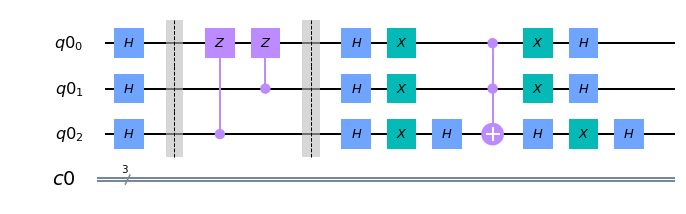

In [18]:
circ.h(q)
circ.draw(output='mpl')

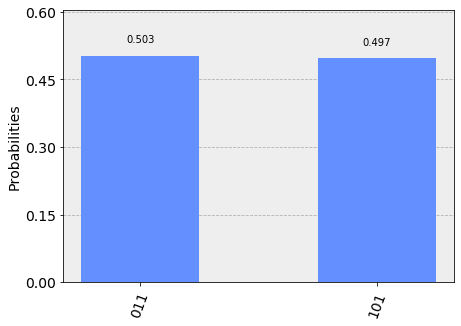

In [19]:
circ.measure(q, c)
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(circ, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Paste the screenshot of the other oracles from the pub [^3-qubit-search]

## How to do the database search?

## Questions

1. We know the marked state to create the oracle. So the Grover algorithm gives us the same ouptpu. What for use the algo? The real reason for me is use it when I don't know the marked state - only the constraints it has to meet.

## Refferences

- [^ibm-textbook-grover]: https://community.qiskit.org/textbook/ch-algorithms/grover.html
- [^3-qubit-search]: C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7, arXiv:1703.10535
- [^lh-tut-qubytes]: lukaszherok.com